# 04-Telluric contamination



## 0 Packages and data

In [ ]:
cd /content

/content


In [ ]:
!git clone https://github.com/folsomcp/specpolFlow

Cloning into 'specpolFlow'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 323 (delta 136), reused 259 (delta 85), pack-reused 0
Receiving objects: 100% (323/323), 6.20 MiB | 9.30 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [ ]:
import specpolFlow as pol
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
import copy

loading specpolFlow package
importing specpolFlow.iolsd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/Shareddrives/BeStarsMiMeS/

/content/drive/Shareddrives/BeStarsMiMeS


## 1. For Federico: making a graph of model versus data for one observation, and make a list of wavelength regions that we will ignore because of telluric contamination

### Functions that will be used below (move this to a module on the github, maybe? split and splice could go into the iolsd.observation class, once there is a check added in case there are no spectral orders present -- i.e. for already mearged observations)

In [ ]:
def read_disk(file):
  '''
  Read a synthetic spectrum from a s3div output

  :param file: The filename
  :rtype: wave, flux -- the wavelength in nm, and the normalized flux. 
  '''
  with open(file) as f:
    lines = f.readlines()
  # number of atomic lines in the header of the file
  natomic = int(lines[0].split(sep='-')[0])
  nwave=int(lines[natomic+1].split()[0])
  data = np.genfromtxt(lines[natomic+2:natomic+1+nwave])
  return(data[:,0]/10.0, data[:,1])

def split_order(data):
  '''
  Split an observation object into a list of observation objects with one order per item
  '''
  # one order is where the wavelength backtracks. 
  ind = np.where((data.wl[1:]-data.wl[0:-1]) < 0)[0]
  norder = ind.size+1
  ind = np.append(-1,ind)
  ind = np.append(ind,data.wl.size)
  print('{} orders'.format(norder))

  list_order=[]
  for i in range(0,norder):
    list_order.append(data[ind[i]+1:ind[i+1]])
 
  return(list_order)
  
def splice_order(list_order):
  '''
  Concatenate a list of observation objects (usually split into a list of orders by split_order function). Note: it does not merge the orders overlaps.
  '''
  wl = np.array([])
  specI = np.array([])
  specV = np.array([])
  specN1 = np.array([])
  specN2 = np.array([])
  specSig = np.array([])
  for item in list_order:
    wl=np.append(wl,item.wl)
    specI=np.append(specI,item.specI)
    specV=np.append(specV,item.specV)
    specN1=np.append(specN1,item.specN1)
    specN2=np.append(specN2,item.specN2)
    specSig=np.append(specSig, item.specSig)
  return(pol.iolsd.observation(wl, specI, specV, specN1, specN2, specSig, header=list_order[0].header))

def rshift(wave, radvel):
  '''
  Shift a spectrum in terms of radial velocity. The wavelength array and the velocity arrays must be defied as astropy units quantities.
  The new wavelength array is returned in the same units as the initial wavelength array. 
  '''
  return( (wave + wave*radvel/const.c).to(wave.unit).value )


### 2.1 Demo with a single observation

In [ ]:
# Making sure we are in the right directory
! pwd

/content/drive/Shareddrives/BeStarsMiMeS


In [ ]:
star = 'hd6226'
obs = '1'
vradCorrected = -70.0
ModelCode='T15000G40'

* reading the observations and separating it into a list of orders 
* reading the model and shifting to the right radial velocity
* reading the line mask

In [ ]:
# reading the observed spectrum
file_obs = 'NormalizedSpectra/{}_{}.s'.format(star, obs)
data_obs = pol.iolsd.read_spectrum(file_obs)
# splitting the observed spectrum by order
list_order = split_order(data_obs)

# reading the model spectrum
file_mod = 'Synth-diskint-spectra/{}.dsk'.format(star)
mod_wave, mod_flux = read_disk(file_mod)

# shifting the model spectrum for its radial velocity
# (note the rshift function asks for numpy unit quantities)
mod_wave_shift = rshift(mod_wave*u.nm, vradCorrected*u.km/u.s)

file_mask='Masks/{}_depth0.1.mask'.format(ModelCode)
mask = pol.iolsd.mask(fname=file_mask)


37 orders


In [ ]:
## This is a list of wavelength where we expect a spectral line in the data. 
print(mask.wl)

[370.5001 370.5001 370.5011 370.5012 370.5147 370.6024 371.293  371.5172
 372.513  372.7033 373.0839 373.2862 373.2873 373.6902 373.7673 374.1638
 374.5943 374.8487 375.5568 375.6106 375.9291 375.9462 376.1321 376.2892
 376.8784 376.9459 378.3343 378.4862 379.6124 380.5743 380.6526 381.1745
 381.4124 381.9603 381.9603 381.9613 381.9614 381.9758 382.7085 383.1379
 383.3552 384.5183 384.8211 384.9554 385.0386 385.3664 385.6018 386.2595
 386.747  386.7482 386.763  387.1791 388.8605 388.8646 388.8649 389.2288
 390.0539 390.0675 390.6035 391.3461 391.8968 392.0681 392.3445 392.6535
 393.3264 393.3655 393.3659 393.366  393.3661 393.3664 393.5961 393.8967
 396.4729 396.846  396.8465 396.8467 396.8469 397.7565 399.178  399.3499
 399.4997 399.8759 400.9258 402.3973 402.4551 402.6185 402.6187 402.6187
 402.6198 402.6199 402.6358 402.875  406.7031 407.5452 407.678  412.0811
 412.0824 412.0991 412.8054 413.0872 413.0894 413.2984 414.2259 414.3761
 414.506  414.6912 415.3068 416.2665 416.8384 416.8

Below, there is a graph of a part of the observed spectrum (a spectral order). 

To this, the model spectrum is overplotted. We cannot see the details of the comparison, because matplotlib automatically adjust the range of the graph to show everything
* [X] Add a condition in the loop to restrict the range of each graph to the maximum extend of the observersed spectrum. 
* [X] There is an array of wavelength above called mask. For each graph, add a thin vertical line at the x-position of each of these wavelengths (they should correspond to spectral lines in the observations. 
* [X] You will notice a lot of very narrow and strong spectral lines in the observations (that do not appear in the data). These are spectral lines that are due to the atmosphere of the Earth. In a file, make a list of wavelength regions (start end) were the contamination is very large. We will exclude these from our calculations later on. 
* [X] Read out the datafile with the list of regions to exclude, and add a piece of code to the loop that will shade out these regions in light grey (ax.fill_between works well for things like that)


## Plotting different orders of spectral observations and model, with the star's spectral MASK lines and identifying telluric contamination.

The motivation of this notebook is to:

* Obtain a direct comparison between the observed spectrum and the model's prediction.

* Plot in the spectrum the spectral lines of the star (MASK).

* Identify the atmospheric spectral lines and erase them from the analysis. 

The next block of code mounts this notebook into the drive, and extracts the information from the spreadsheet _04-ContaminationregionsWL_, which contains the intervals of wavelenght were contamination was observed. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cd /content/drive/Shareddrives/BeStarsMiMeS/BeStars\ Notebooks

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

!pwd
spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/19lS0Xg-2ZUs0ps8jZ-JM3pR1YIuC_lWvRMpFAM5VUYI/edit?usp=sharing')

# Get the name of all of the sheets in the spreadsheet file
print(spreadsheet.worksheets())

# Select the sheet that we want
worksheet = spreadsheet.worksheet("WLRegions")

# get_all_values gives a list of rows.
rows = worksheet.get_all_records()
print(rows[0:2])

# Put the sheet containing the target information into a 
import pandas as pd
WLRegions = pd.DataFrame.from_records(rows)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/BeStarsMiMeS
[<Worksheet 'Sheet1' id:0>]
[{'WLStart': 587.5, 'WLFinish': 590}, {'WLStart': 591.5, 'WLFinish': 595}]


The next loop plots the different orders obtained, in which each order overlaps the previous and the next orders, but represents a different portion of the spectrum. 

Spectral lines (mask) were plotted as dotted vertical black lines. These sometimes follow both the observation and the model's patterns, with varying magnitude. 

With the data from the spreadsheet used above, the regions with considerable telluric contamination can be shaded in grey.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_

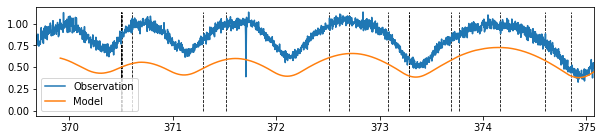

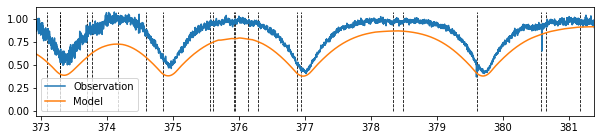

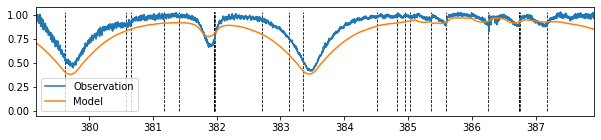

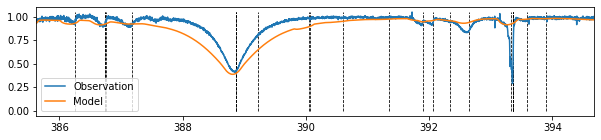

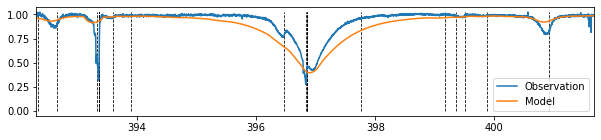

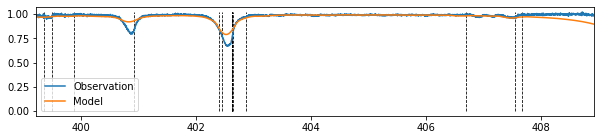

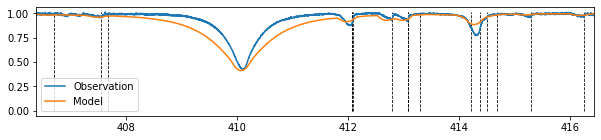

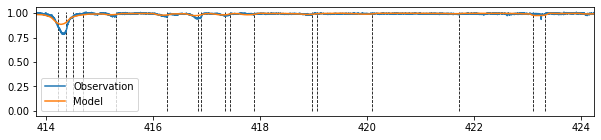

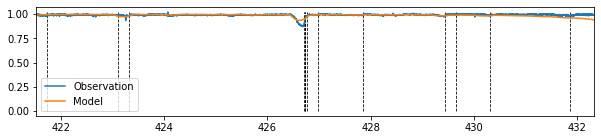

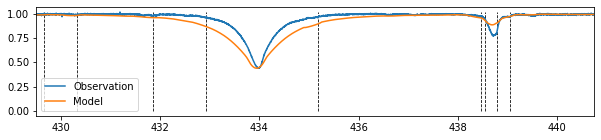

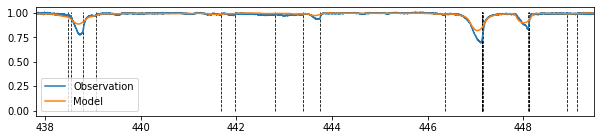

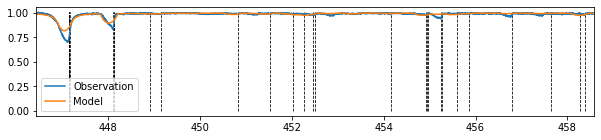

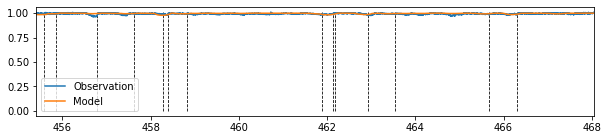

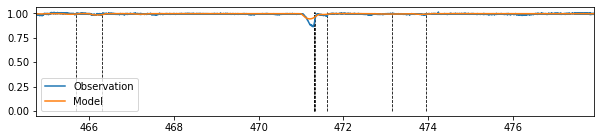

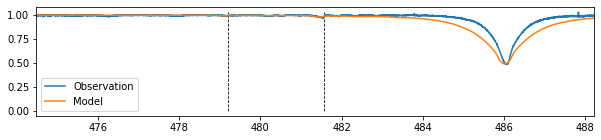

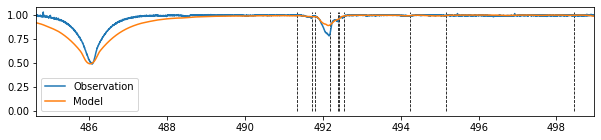

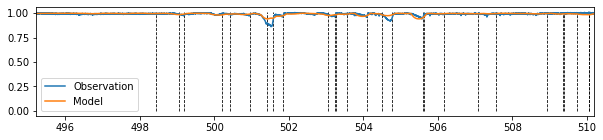

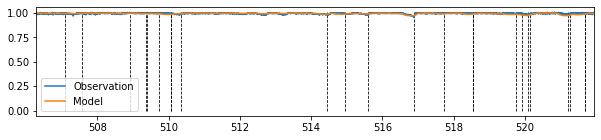

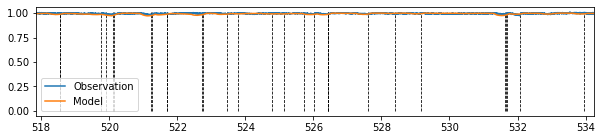

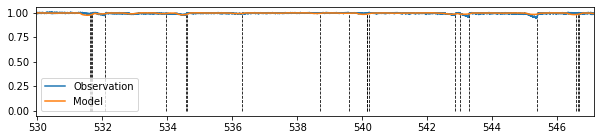

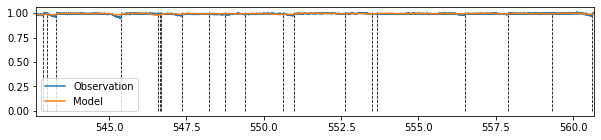

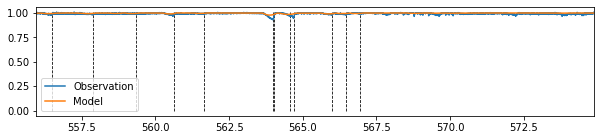

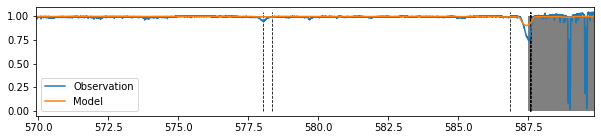

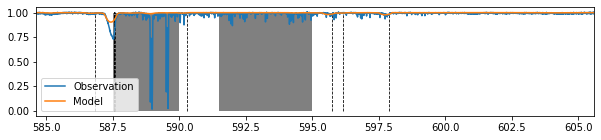

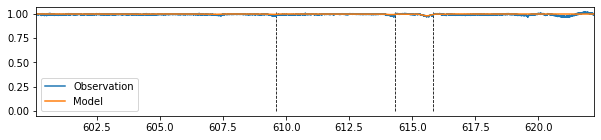

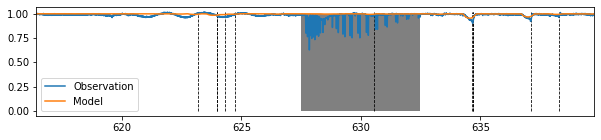

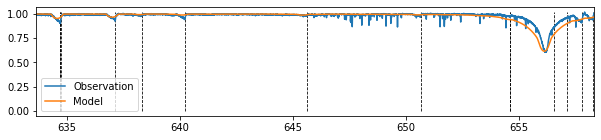

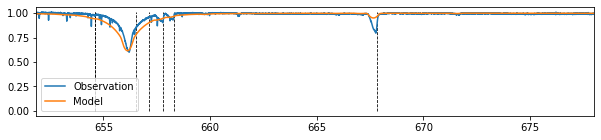

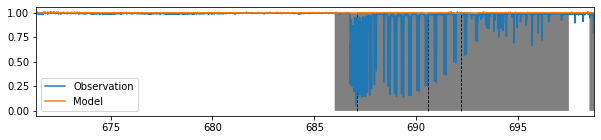

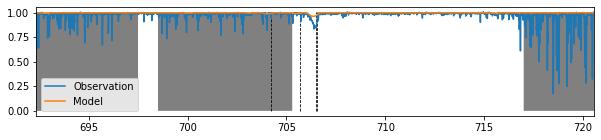

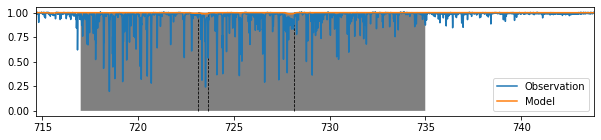

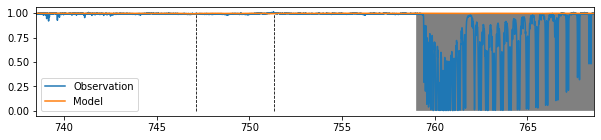

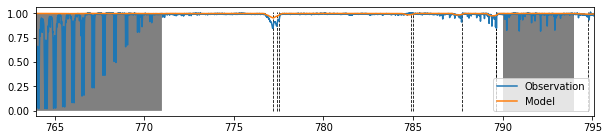

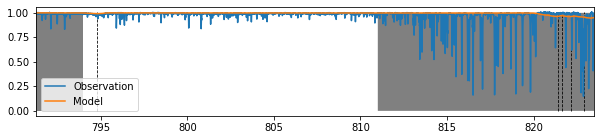

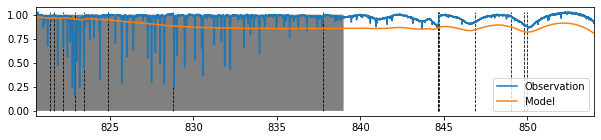

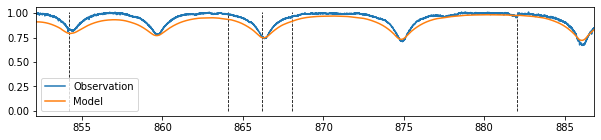

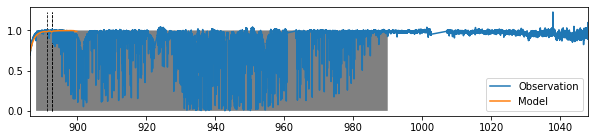

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('TelluricContamination.pdf') as pdf:

  for order in list_order:
    fig, ax = plt.subplots(1,1, figsize=(10,2))
    ax.plot(order.wl, order.specI, label='Observation')
    #Setting limits to axes
    ax.set_xlim([order.wl[0],order.wl[-1]])
    #Plotting spectral lines as black
    ax.vlines(x=mask.wl,ymin=0, ymax=np.max(order.specI),color='k',linestyle='--',lw=0.8)
    #Shading contaminated regions to grey
    ax.plot(mod_wave_shift, mod_flux, label='Model')
    ax.legend(loc=0)

    for i in range(0,np.shape(WLRegions)[0]):
      Xr = np.arange(WLRegions.loc[i,'WLStart'],WLRegions.loc[i,'WLFinish'],0.01)
      ax.fill_between(Xr,y1=0,y2=1,facecolor ='grey')
    pdf.savefig(fig,box_inches='tight')

The next step is to identify which spectral lines enter the shaded regions and discard them from the analysis. The method _mask.iuse_ gives an array with _ones_ and _zeros_, with each element linked to a respective spectral line. If the element has a _one_, the spectral line is used and if it has a _zero_ it is not taken into account for the LSD.   

The next code block takes the regions from the pandas format spreadsheet into a matrix called _regions_ and loops for every line to see if it is inside a shaded region, in which case the _mask.iuse_ value for that line is changed to _zero_. The last line saves the mask with the name _'mask_federico_test'_. 

In [ ]:
#Place the regions into a matrix

L = np.shape(WLRegions.loc[:,'WLStart'])[0]

regions = np.zeros((L,2))

regions[:,0] = WLRegions.loc[:,'WLStart']
regions[:,1] = WLRegions.loc[:,'WLFinish']



#Identifying if a line is inside or outside the regions

dcard = []
for lines in mask.wl:
  for i in range(0,np.size(regions[:,0])):
    if regions[i,0] < lines < regions[i,1]:
      dcard.append(lines)

#Creating a list with the mask.wl elements
mask_list = mask.wl.tolist()

for line in dcard:
  index = (mask_list).index(line)
  mask.iuse[index]=0

#print(mask.iuse)
#mask.save('mask_federico_test')



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0]


This last code block retrieves the original mask and the test mask that was saved in the last line of the previous block. Lines which have a _one_ value on the _mask.iuse_ array are added to a new array which plots the vertical lines alongside with the spectrum. The expected result is of course that no lines are found telluric contaminated regions. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

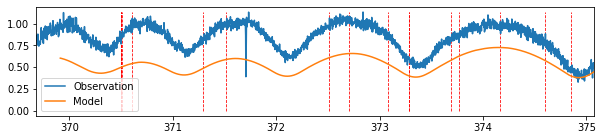

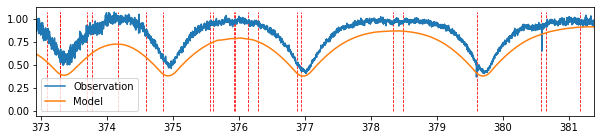

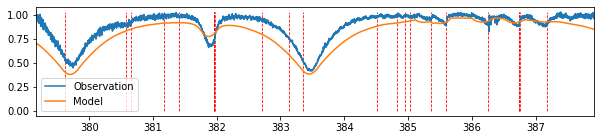

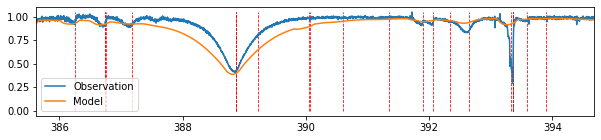

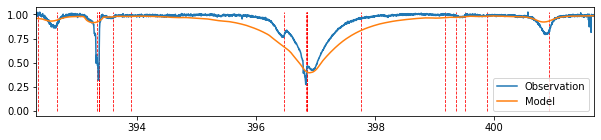

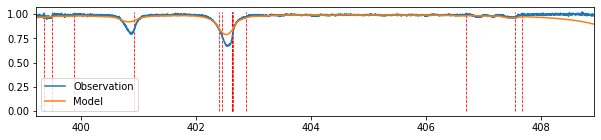

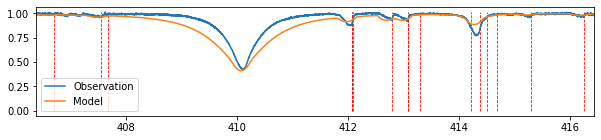

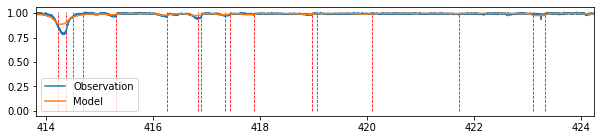

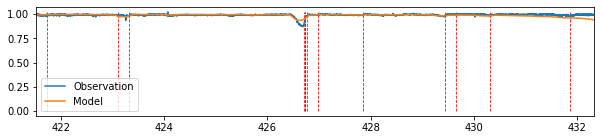

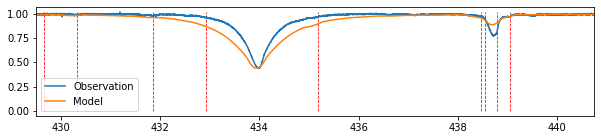

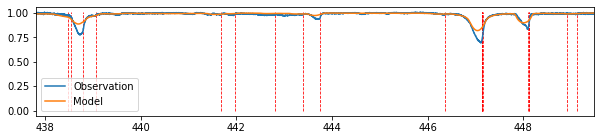

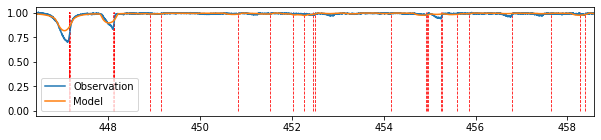

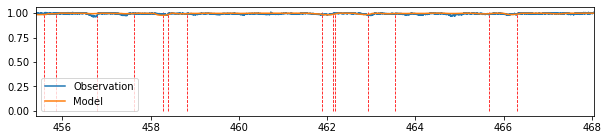

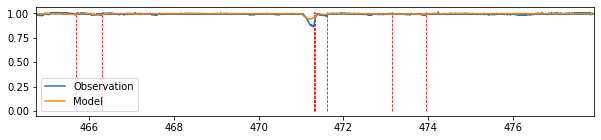

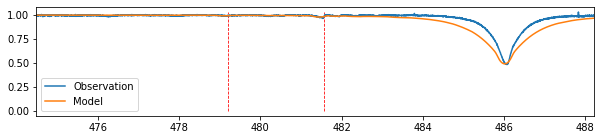

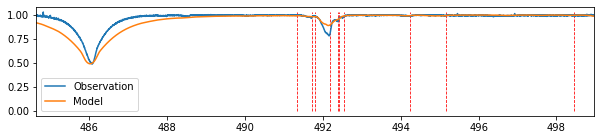

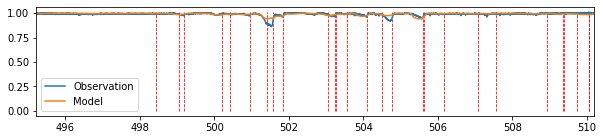

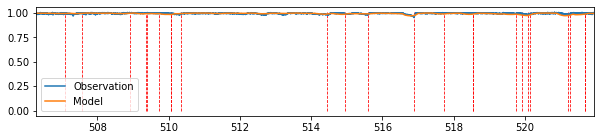

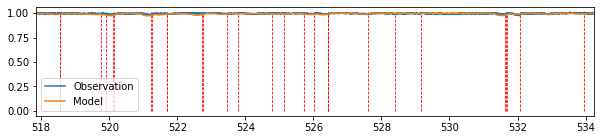

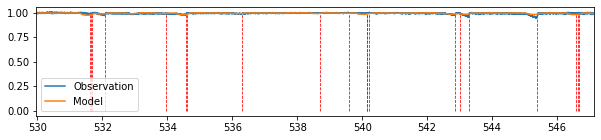

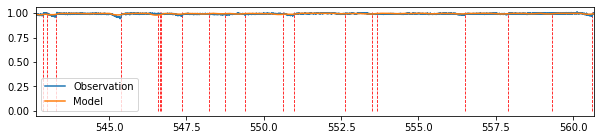

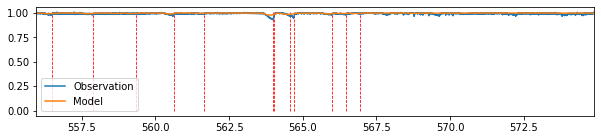

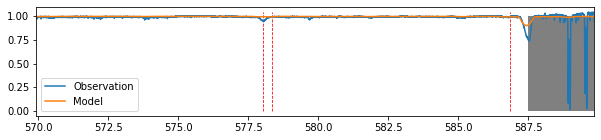

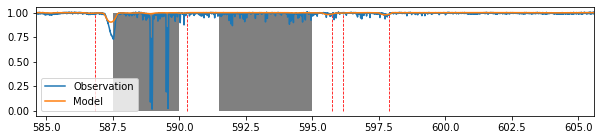

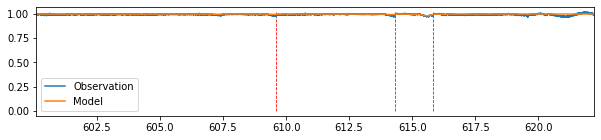

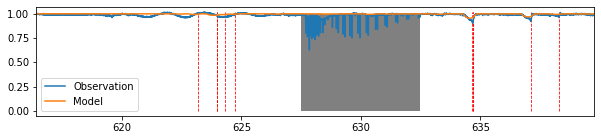

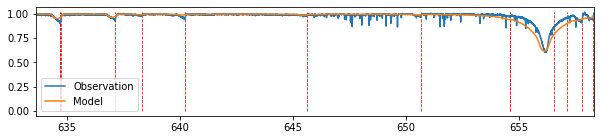

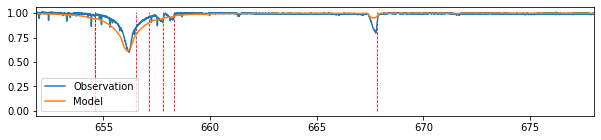

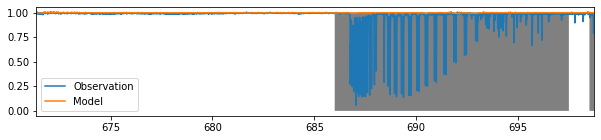

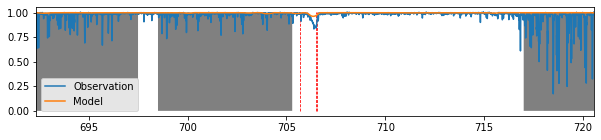

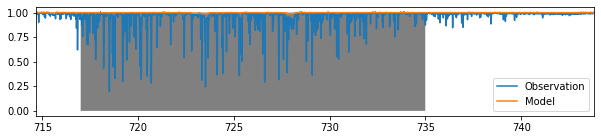

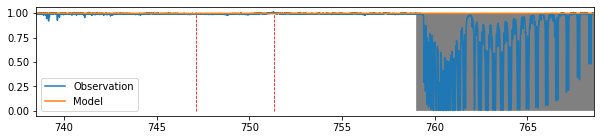

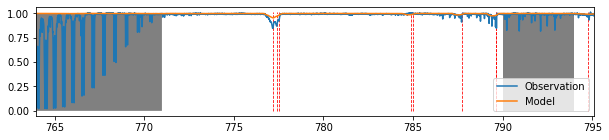

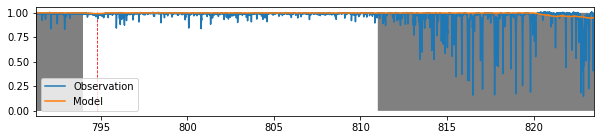

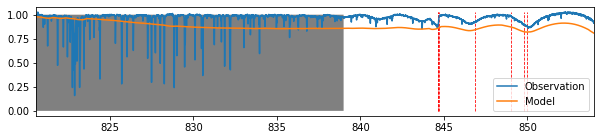

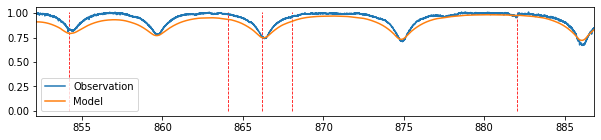

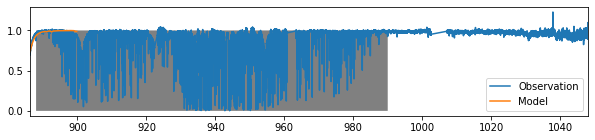

In [ ]:
mask = pol.iolsd.mask(fname=file_mask)
mask_test = pol.iolsd.mask(fname='mask_federico_test')


from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('TelluricContamination_test.pdf') as pdf:

  l = np.size(mask_test.wl)
  spec_lines = []
  for i in range(0,l):
    if mask_test.iuse[i]==1:
      spec_lines.append(mask_test.wl[i])



  for order in list_order:
    fig, ax = plt.subplots(1,1, figsize=(10,2))
    ax.plot(order.wl, order.specI, label='Observation')
    #Setting limits to axes
    ax.set_xlim([order.wl[0],order.wl[-1]])
    #Vertical lines
    ax.vlines(x=spec_lines,ymin=0, ymax=np.max(order.specI),color='r',linestyle='--',lw=0.8)
    #Shading contaminated regions to grey
    ax.plot(mod_wave_shift, mod_flux, label='Model')
    ax.legend(loc=0)

    for i in range(0,np.shape(WLRegions)[0]):
      Xr = np.arange(WLRegions.loc[i,'WLStart'],WLRegions.loc[i,'WLFinish'],0.01)
      ax.fill_between(Xr,y1=0,y2=1,facecolor ='grey')

    #pdf.savefig(fig,box_inches='tight')